## Expected Free Energy minimization for mobile robot navigation

Wouter Kouw

### Dynamics

Consider a mobile robot that moves according to:

$$\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ \dot{x}_{1,k} \\ \dot{x}_{2,k} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ \dot{x}_{1,k-1} \\ \dot{x}_{2,k-1} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \Delta t & 0 \\ 0 & \Delta t \end{bmatrix}}_{B} \underbrace{\begin{bmatrix} u_{1,k} \\ u_{2,k}\end{bmatrix}}_{u_k} + q_k \, .$$

Process noise is white, $q_k \sim \mathcal{N}(0, Q)$, with 

$$Q = \begin{bmatrix} \frac{\Delta t^3}{3} \rho_1 & 0 & \frac{\Delta t^2}{2} \rho_1 & 0 \\
                      0 & \frac{\Delta t^3}{3} \rho_2 & 0 & \frac{\Delta t^2}{2} \rho_2 \\
                      \frac{\Delta t^2}{2} \rho_1 & 0 & \Delta t \rho_1 & 0 \\
                      0 & \frac{\Delta t^2}{2} \rho_2 & 0 & \Delta t \rho_2 \end{bmatrix} \, .$$

### Observations

Position is sensed, perturbed by Gaussian noise:

$$y_k = C z_k + r_k$$

where $r_k$ is measurement noise with covariance matrix $R$. 

## Experiments

In [2]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

using Revise
using Colors
using Optim
using JLD2
using MeshGrid
using ForwardDiff
using ProgressMeter
using LinearAlgebra
using Distributions
using StatsPlots
using Plots
default(label="", grid=false, markersize=3, margin=15Plots.pt)

includet("../Robots.jl"); using. Robots
includet("../MARXAgents.jl"); using. MARXAgents
includet("../util.jl");

  Activating project at `c:\Syndr\Wouter\Onderzoek\Projecten\tue\efe-acquisition\narx-efe`


In [4]:
# Time
Δt = 0.1
len_trial = 100
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 1;

# Dimensionalities
Mu = 3
My = 3
Dy = 2
Du = Dy
Dx = My*Dy + Mu*Du
Dz = 4

# Setpoint (desired observation)
z_star = [-5., 5., 0.0, 0.0]
goal = MvNormal(z_star[1:2], 1.0*diagm(ones(2)))

# Parameters
σ = 1e-4*ones(Dy)
ρ = 1e-3*ones(Dy)

# Limits of controller
u_lims = (-1.0, 1.0)
opts = Optim.Options(time_limit=20)

# Initial state
z_0 = [-5., -5., 0., 0.]

# Start robot
fbot  = FieldBot(ρ,σ, Δt=Δt, control_lims=u_lims)

# Prior parameters
ν0 = 10
Ω0 =  1e0*diagm(ones(Dy))
Λ0 = 1e-3*diagm(ones(Dx))
M0 = 1e-8*randn(Dx,Dy)
Υ  = 1e-1*diagm(ones(Dy))

# Start agent
agent = MARXAgent(M0,Λ0,Ω0,ν0,Υ, goal, Dy=Dy, Du=Du, delay_inp=Mu, delay_out=My)

MARXAgent(2, 12, 2, [0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0], 3, 3, [-5.2045351439633335e-9 -1.7255351779003892e-9; -2.416830836548804e-9 2.1500297405663162e-8; … ; -2.047125980665204e-8 -1.4405079955605468e-8; 3.777540708013408e-9 8.692864751329535e-9], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001], [1.0 0.0; 0.0 1.0], 10.0, [0.1 0.0; 0.0 0.1], FullNormal(
dim: 2
μ: [-5.0, 5.0]
Σ: [1.0 0.0; 0.0 1.0]
)
, 1, 10, Inf)

### System identification

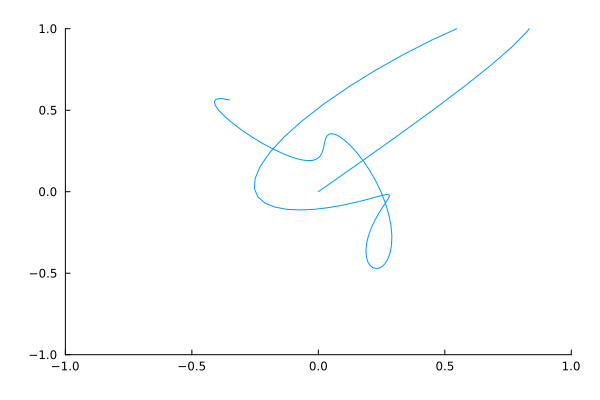

In [5]:
# Fix controls
u_A = rand(10,2)*30
u_ϕ = rand(10,2)*3
u_sim = [mean([u_A[i,1]*sin.(u_ϕ[i,1].*tsteps) for i = 1:10])' ./ 10;
         mean([u_A[i,2]*sin.(u_ϕ[i,2].*tsteps) for i = 1:10])' ./ 10]
plot(u_sim[1,:], u_sim[2,:], xlims=u_lims, ylims=u_lims)

In [6]:
# Preallocate
z_sim   = zeros(Dz,len_trial)
y_sim   = zeros(Dy,len_trial)
F_sim   = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

# Fix starting state
z_sim[:,1] = z_0
y_sim[:,1] = emit(fbot, z_sim[:,1])

for k in 2:len_trial

    # Predictions
    x_k = [agent.ubuffer[:]; agent.ybuffer[:]]
    η,μ,Ψ = posterior_predictive(agent, x_k)
    preds_m[:,k] = μ
    preds_S[:,:,k] = inv(Ψ) * η/(η - 2)

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])

    # Update parameters
    MARXAgents.update!(agent, y_sim[:,k], u_sim[:,k-1])

    Ms[:,:,k] = agent.M
    Λs[:,:,k] = agent.Λ
    Ωs[:,:,k] = agent.Ω
    νs[k]     = agent.ν

    # Track free energy
    F_sim[k] = agent.free_energy
end

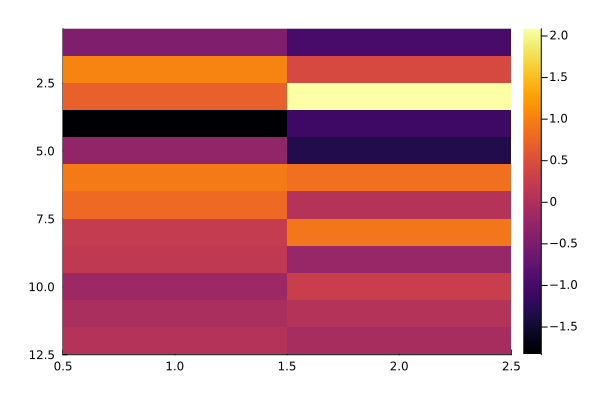

In [7]:
heatmap(Ms[:,:,end], yflip=true)

In [8]:
M_ = Ms[:,:,end]
Λ_ = Λs[:,:,end]
Ω_ = Ωs[:,:,end]
ν_ = νs[end]

109.0

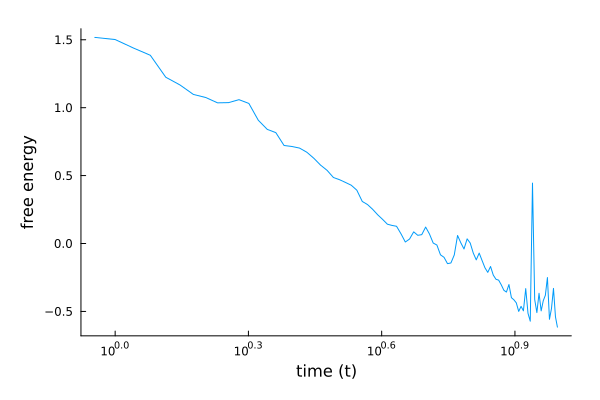

In [9]:
twin = 10:len_trial
plot(tsteps[twin], F_sim[twin], xlabel="time (t)", ylabel="free energy", xscale=:log10)

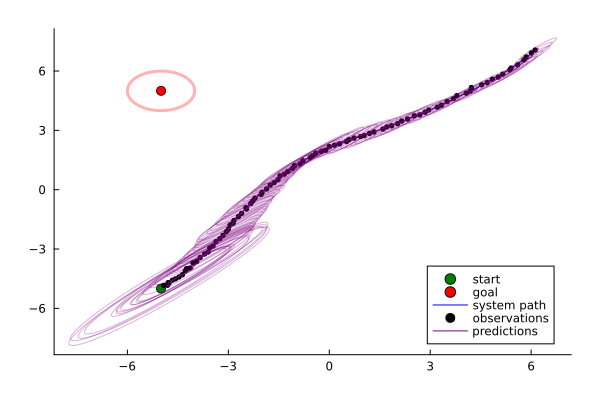

In [10]:
twin = 10:len_trial

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")
scatter!(y_sim[1,twin], y_sim[2,twin], label="observations", color="black")

plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, fillalpha=0.001, linecolor="purple", color="purple")
end
plot!()
# plot!(aspect_ratio=:equal, xlims=(-1,1), ylims=(-1,1))

### Control

In [44]:
# Time
Δt = 0.1
len_trial = 3000
tsteps = range(0, step=Δt, length=len_trial)
len_horizon = 6;

trialnum = 6

6

In [45]:
# Start agent
# agent = MARXAgent(M_,Λ_,Ω_,ν_,Υ, goal, Dy=Dy, Du=Du, delay_inp=Mu, delay_out=My, time_horizon=len_horizon)
agent = MARXAgent(M0,Λ0,Ω0,ν0,Υ, goal, Dy=Dy, Du=Du, delay_inp=Mu, delay_out=My, time_horizon=len_horizon)

# Preallocate
y_pln  = (zeros(len_trial, Dy,len_horizon), zeros(len_trial, Dy,Dy,len_horizon))
z_sim  = zeros(Dz,len_trial)
y_sim  = zeros(Dy,len_trial)
u_sim  = zeros(Du,len_trial)
F_sim  = zeros(len_trial)
preds_m = zeros(Dy,len_trial)
preds_S = repeat(diagm(ones(Dy)), outer=[1, 1, len_trial])

Ms = zeros(Dx,Dy,len_trial)
Λs = zeros(Dx,Dx,len_trial)
Ωs = zeros(Dy,Dy,len_trial)
νs = zeros(len_trial)

Nu = 21
ur = range(u_lims[1], stop=u_lims[2], length=Nu)
ux,uy = meshgrid(ur,ur)
uu = [ux[:]'; uy[:]']
Ju = zeros(Nu^2, len_trial)
CE = zeros(Nu^2, len_trial)
MI = zeros(Nu^2, len_trial)

# Initial state
z_sim[:,1] = z_0

policy = zeros(Du*len_horizon)

@showprogress for k in 2:len_trial

    "Predict observation"
    
    x_k = [agent.ubuffer[:]; agent.ybuffer[:]]
    η,μ,Ψ = posterior_predictive(agent, x_k)
    preds_m[:,k] = μ
    preds_S[:,:,k] = inv(Ψ) * η/(η - 2)
    
    "Interact with environment"

    # Update system with selected control
    y_sim[:,k], z_sim[:,k] = update(fbot, z_sim[:,k-1], u_sim[:,k-1])
               
    "Parameter estimation"

    # Update parameters
    MARXAgents.update!(agent, y_sim[:,k], u_sim[:,k-1])

    Ms[:,:,k] = agent.M
    Λs[:,:,k] = agent.Λ
    Ωs[:,:,k] = agent.Ω
    νs[k]     = agent.ν

    # Track free energy
    F_sim[k] = agent.free_energy
    
    "Planning"
    
    # Visualize objective
    for ii in 1:Nu^2
      
        # Update control buffer
        ub = MARXAgents.backshift(agent.ubuffer, uu[:,ii])
        xx = [ub[:]; agent.ybuffer[:]]

        # Mutual info 
        MI[ii,k] = mutualinfo(agent, xx)
        CE[ii,k] = crossentropy(agent, xx)
        Ju[ii,k] = MI[ii,k] + CE[ii,k]

    end
    
    # Call minimizer using constrained L-BFGS procedure
    G(u::AbstractVector) = EFE(agent, u)
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(Du*len_horizon), Fminbox(LBFGS()), opts; autodiff=:forward)
    
    # Extract minimizing control
    policy = Optim.minimizer(results)
    u_sim[:,k] = policy[1:Du]

    # # Planning under optimized policy
    planned_obs = predictions(agent, reshape(policy, (Du,len_horizon)), time_horizon=len_horizon)
    y_pln[1][k,:,:]   = planned_obs[1]
    y_pln[2][k,:,:,:] = planned_obs[2]
    
end

In [46]:
jldsave("results/MARXEFE-botnav-trialnum$trialnum.jld2"; agent, Δt, len_trial, len_horizon, F_sim, z_0, z_sim, u_sim, y_sim, y_pln, Ju, MI, CE, Ms, Λs, Ωs, νs, Υ, Nu, uu, ur, u_lims)

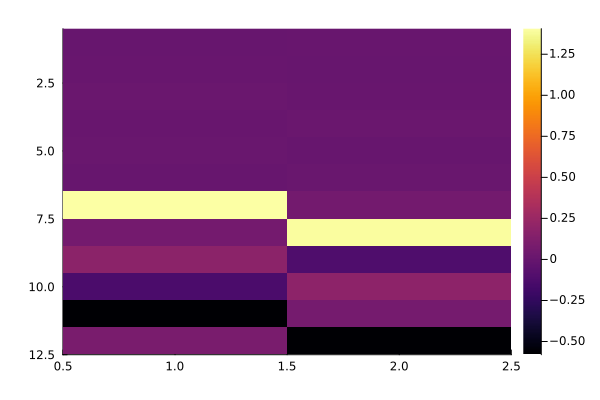

In [25]:
heatmap(Ms[:,:,end], yflip=true)

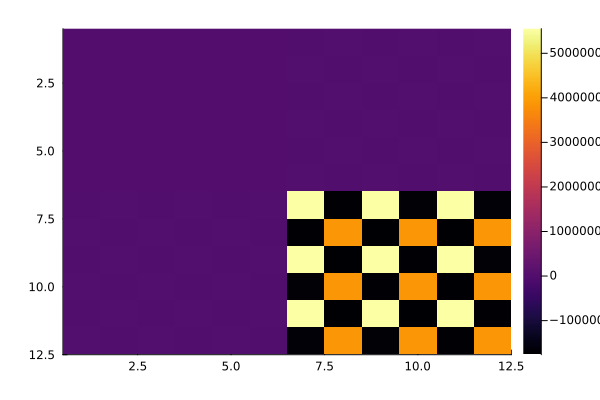

In [26]:
heatmap(Λs[:,:,end], yflip=true)

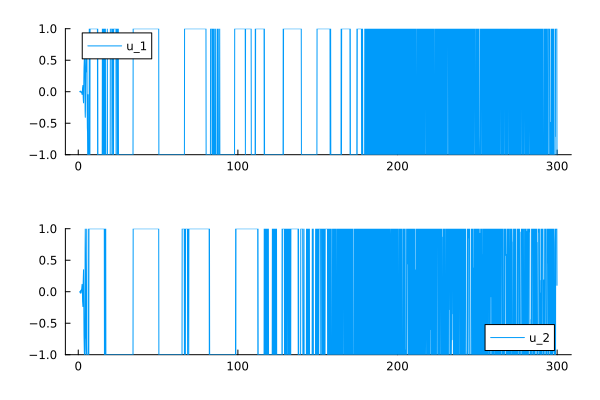

In [47]:
twin = 10:len_trial
p1 = plot(tsteps[twin], u_sim[1,twin], label="u_1", ylims=u_lims)
p2 = plot(tsteps[twin], u_sim[2,twin], label="u_2", ylims=u_lims)
plot(p1,p2, layout=(2,1))

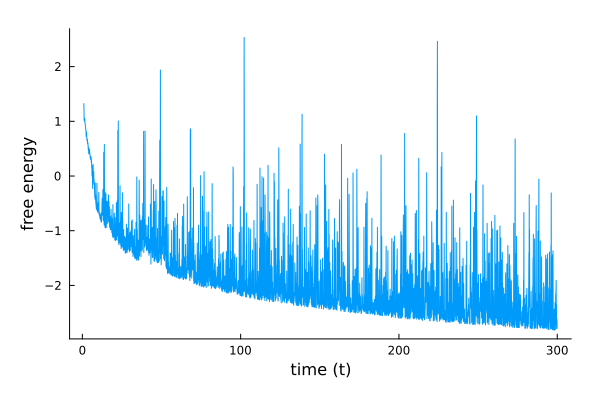

In [48]:
twin = 10:len_trial
plot(tsteps[twin], F_sim[twin], xlabel="time (t)", ylabel="free energy")

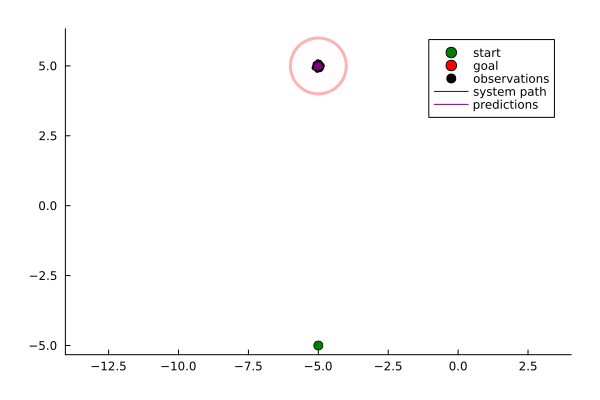

In [62]:
# twin = len_trial-100:len_trial
twin = 2300:2400

scatter([z_0[1]], [z_0[2]], label="start", color="green", markersize=5)
scatter!([mean(goal)[1]], [mean(goal)[2]], label="goal", color="red", markersize=5)
covellipse!(mean(goal), cov(goal), n_std=1., linewidth=3, fillalpha=0.01, linecolor="red", color="red")
scatter!(y_sim[1,twin], y_sim[2,twin], label="observations", color="black")
plot!(z_sim[1,twin], z_sim[2,twin], label="system path", color="blue")

for kk = twin
    covellipse!(preds_m[:,kk], preds_S[:,:,kk], n_std=1, alpha=0.001, fillalpha=0.0001, color="purple")
end
plot!(preds_m[1,twin], preds_m[2,twin], label="predictions", color="purple")
plot!(aspect_ratio=:equal)
# plot!(xlims=(-3,3), ylims=(-3,3))